In [62]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

### Define Constants

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [63]:
### Prepare Traing Data

os.getcwd()

filenames = os.listdir("./train")

# filename = random.sample(filenames,int(0.5*len(filenames)))
newfiles = []
categories = []
for filename in filenames:
    if ".png" in filename:
        newfiles.append(filename)
    category = filename.split('_')[0]
    if category == 'True':
        categories.append(1)
    elif category == 'False':
        categories.append(0)

df = pd.DataFrame({
    'filename': newfiles,
    'category': categories
})

df.head(5)

df.tail()

,filename,category
14391,True_9_000000001153_keypoint.png,1
14392,True_9_000000001154_keypoint.png,1
14393,True_9_000000001155_keypoint.png,1
14394,True_9_000000001156_keypoint.png,1
14395,True_9_000000001157_keypoint.png,1


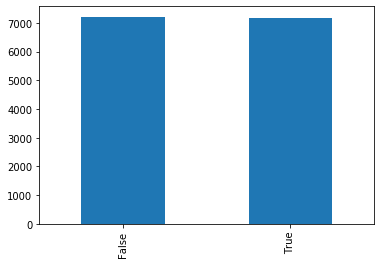

In [83]:
### See Total In count

df['category'].value_counts().plot.bar()

### See sample image

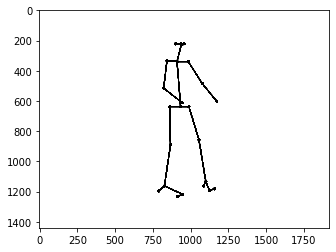

In [84]:
sample = random.choice(filenames)
image = load_img("./train/"+sample)
plt.imshow(image)

In [65]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 64)       

In [66]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [67]:
earlystop = EarlyStopping(patience=10)

In [68]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [69]:
callbacks = [earlystop, learning_rate_reduction]

### Prepare Data

In [70]:
df["category"] = df["category"].replace({0: 'False', 1: 'True'}) 

In [71]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

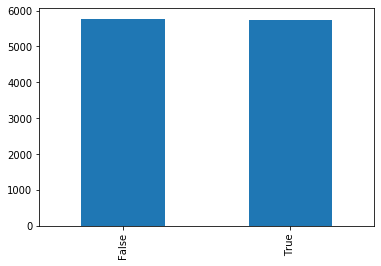

In [72]:
train_df['category'].value_counts().plot.bar()

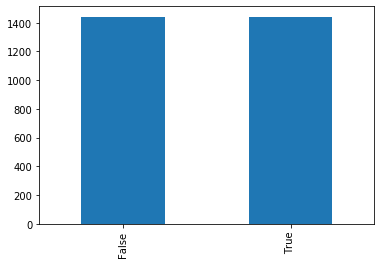

In [73]:
validate_df['category'].value_counts().plot.bar()

In [74]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Traning Generator

In [75]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 11516 validated image filenames belonging to 2 classes.


## Validation Generator

In [76]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2880 validated image filenames belonging to 2 classes.


## See how our generator work

In [77]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


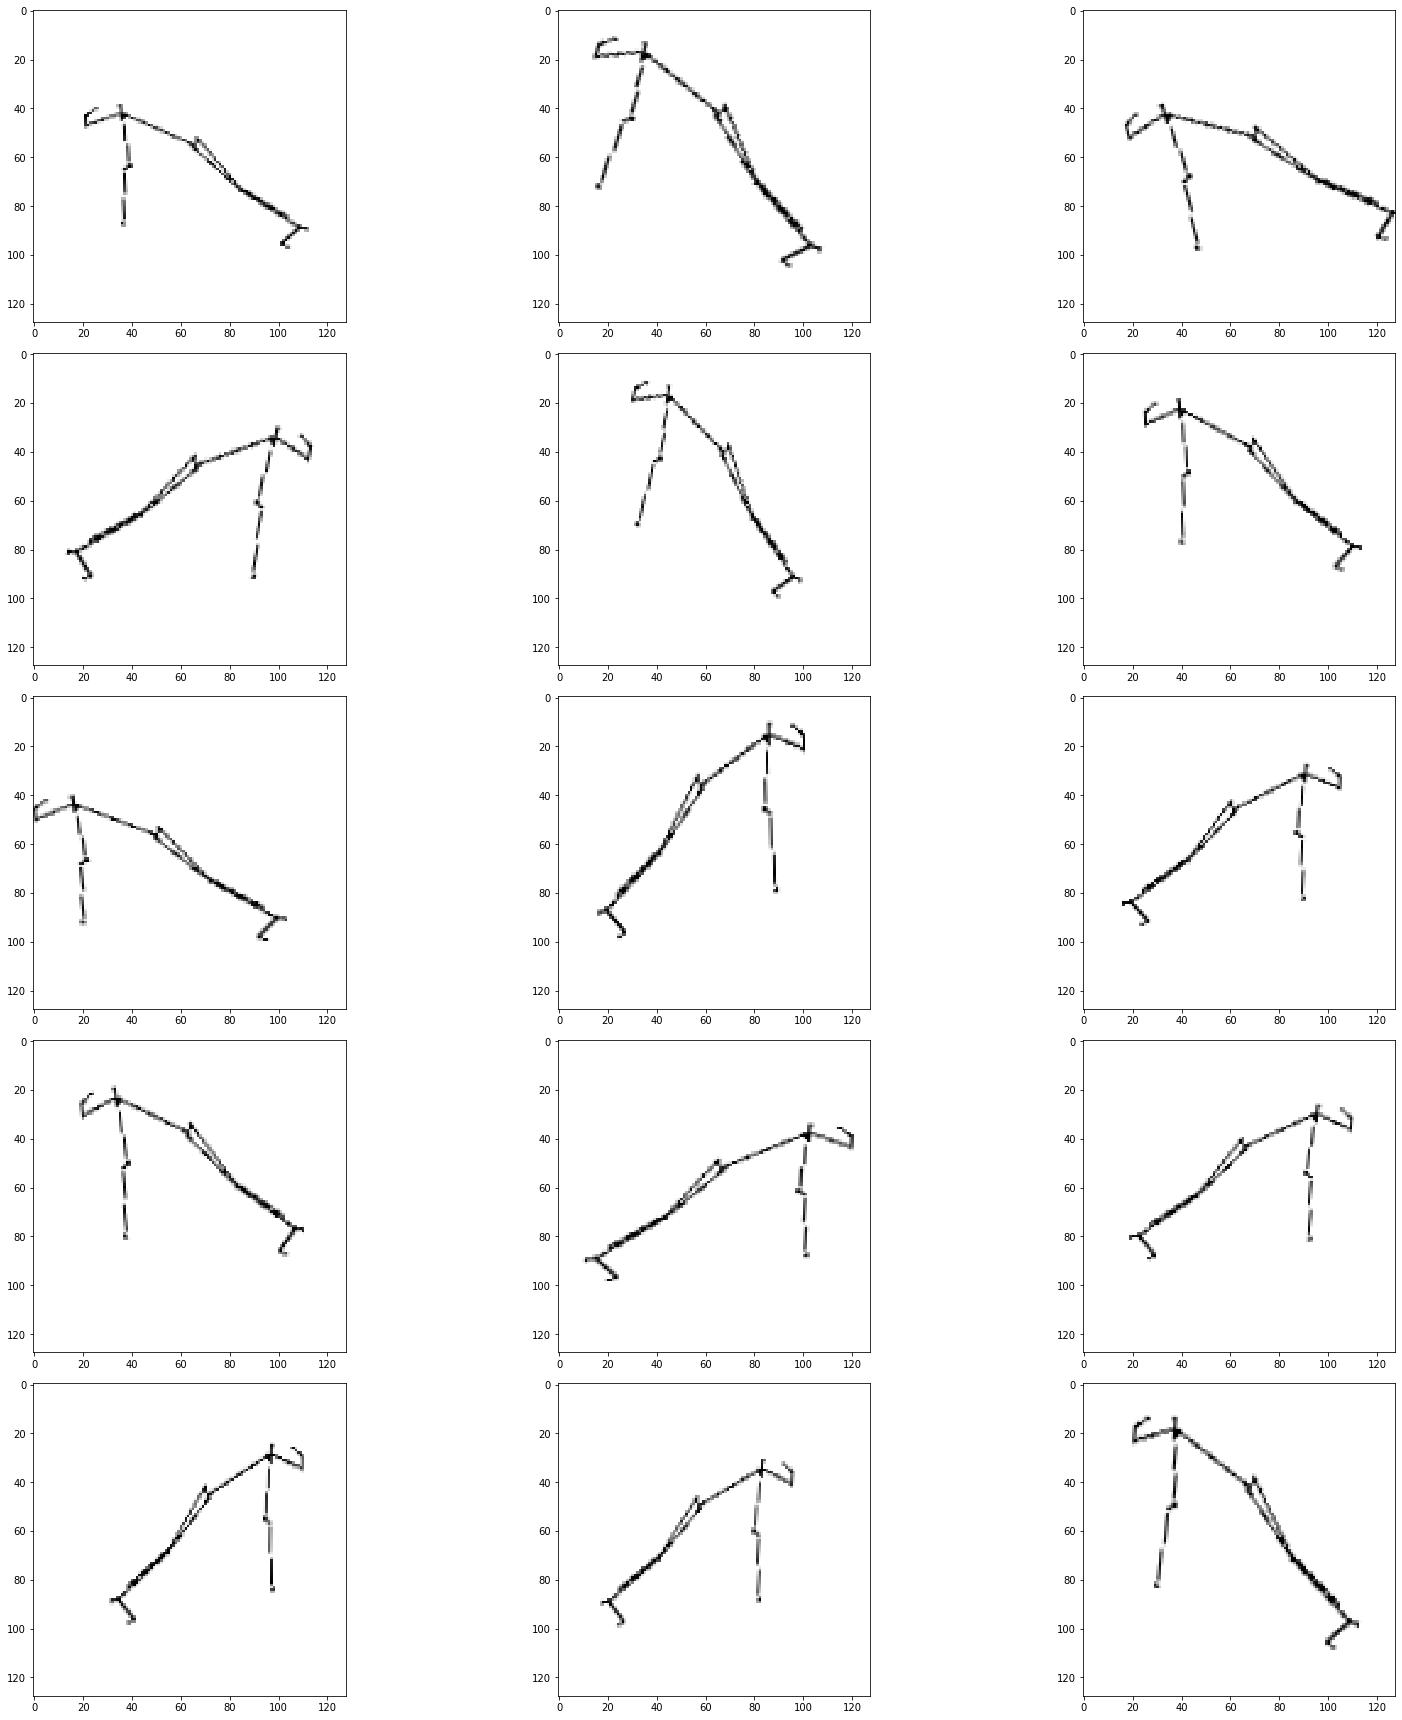

In [78]:
plt.figure(figsize=(24, 24))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model

In [79]:
epochs=3 if FAST_RUN else 3
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
767/767 [==============================] - 840s 1s/step - loss: 0.5096 - accuracy: 0.7903 - val_loss: 0.5124 - val_accuracy: 0.8319
Epoch 2/3


/Users/yiwen/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


767/767 [==============================] - 825s 1s/step - loss: 0.3340 - accuracy: 0.8629 - val_loss: 0.3744 - val_accuracy: 0.8931
Epoch 3/3
767/767 [==============================] - 819s 1s/step - loss: 0.2945 - accuracy: 0.8809 - val_loss: 0.2198 - val_accuracy: 0.8972


In [80]:
model.save_weights("model_2.h5")

## Virtualize Training

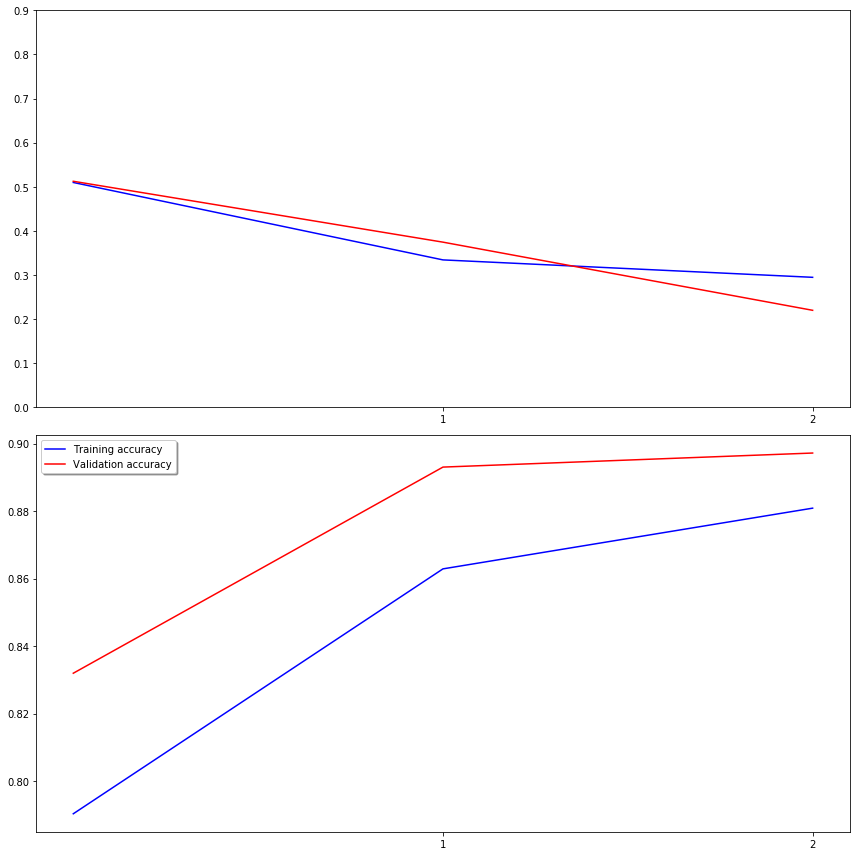

In [85]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prepare Testing Data

In [158]:
test_filenames = os.listdir("./test")[1:]
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [110]:
# fal = 0
# tru = 0
# for file in test_filenames:
#     label = file.split('_')[0]
#     if label == 'False':
#         fal += 1
#     elif label == 'True':
#         tru += 1
# print(fal,tru )

150 75


In [159]:
len(test_df)

609

## Create Testing Generator

In [160]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 609 validated image filenames.


## Predict

In [161]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [162]:
test_df['category'] = np.argmax(predict, axis=-1)

In [163]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [164]:
test_df['category'] = test_df['category'].replace({ 'True': 1, 'False': 0 })

In [165]:
test_df.head()

,filename,category
0,quat_000000000001_keypoint.png,0
1,quat_000000000002_keypoint.png,1
2,quat_000000000003_keypoint.png,1
3,quat_000000000004_keypoint.png,1
4,quat_000000000005_keypoint.png,1


In [126]:
# label = []
# filename = test_df['filename']
# for name in filename:
#     tag = name.split('_')[0]
#     if tag == 'False':
#         label.append(0)
#     elif tag == 'True':
#         label.append(1)

In [128]:
test_df['True_label'] = label

In [136]:
prediction_accuracy = sum(test_df['category'] == test_df['True_label']) / len(test_df)
print('Prediction Accuracy: % f' % prediction_accuracy)

Prediction Accuracy:  0.937778


In [166]:
for i in test_df['category']:
    print(i)

0
1
1
1
1
0
0
0
0
1
1
0
0
1
0
1
1
1
0
1
1
1
1
1
0
0
0
0
1
1
1
1
0
1
1
1
0
1
0
1
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
1
0
0
1
0
0
0
0
0
1
0
0
0
0
0
1
1
1
0
0
1
1
1
0
0
1
1
1
0
1
1
0
0
1
0
1
0
0
0
0
1
1
1
0
1
0
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [168]:
import pickle
with open("squat.txt", 'wb') as f:
    pickle.dump(test_df, f)

## Virtaulize Result

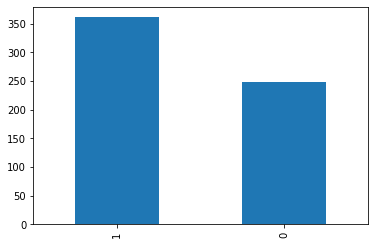

In [167]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

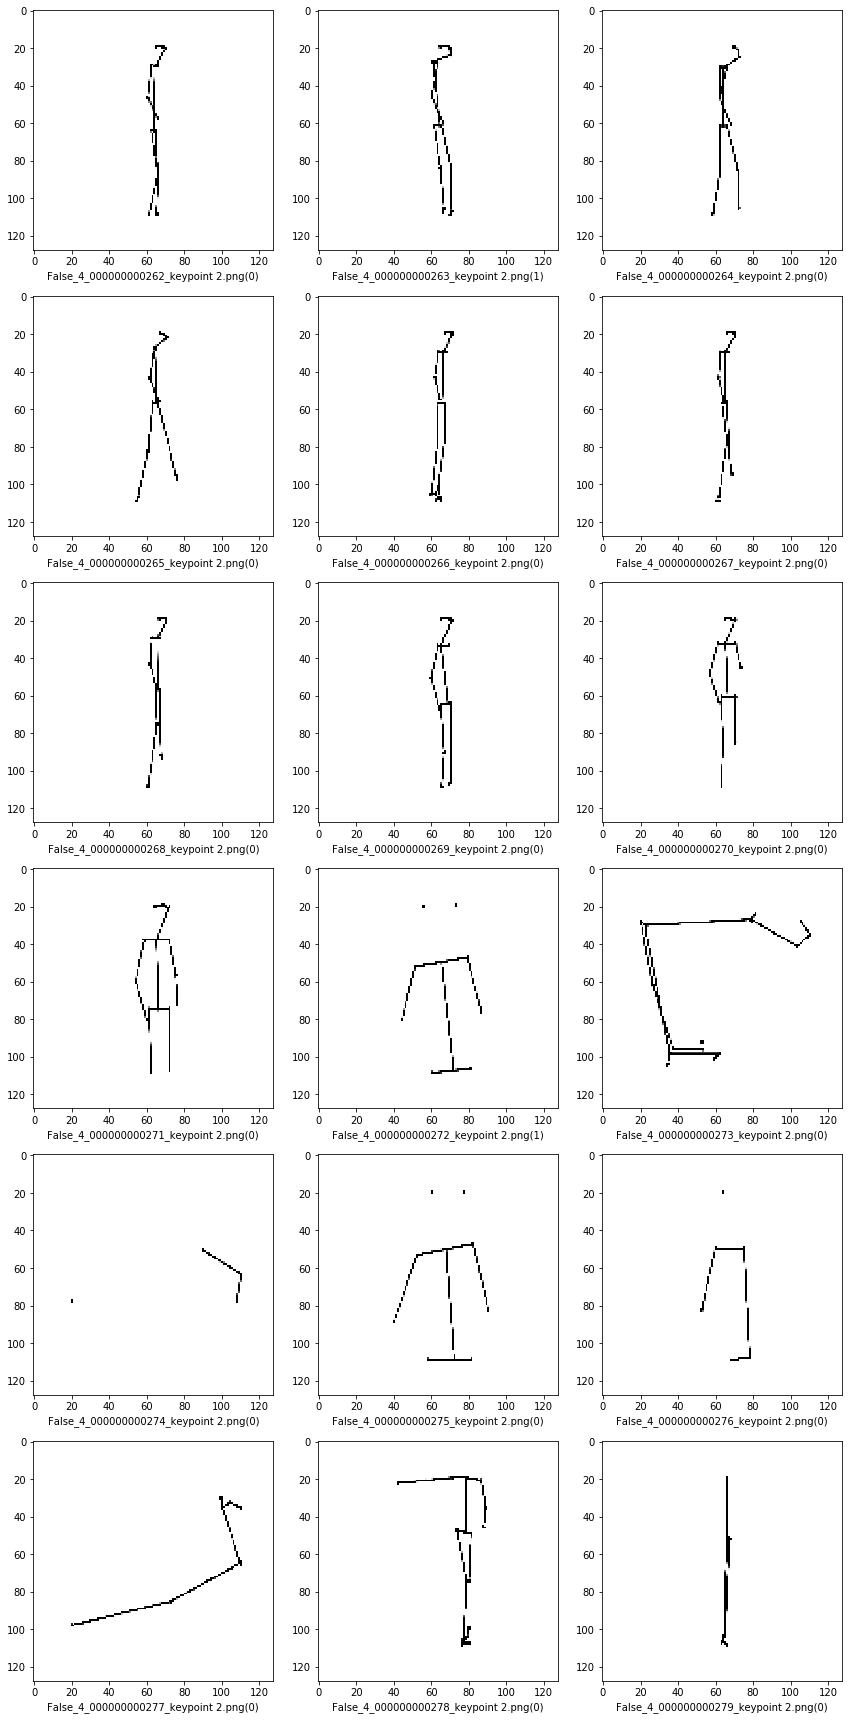

In [118]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()